<a href="https://colab.research.google.com/github/cindykhris/SummerInternship2020/blob/master/PCA_SARS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Principal Component Analysis (PCA) and Visualization using Python

**Introduction**

Description: In this study, I analyzed the gene expression of coronaviruses (CoVs) infections to determine how each virus differs when causing a disease. Here, I focused the analysis on samples derived from SARS-CoV, MERS, and SARS-CoV-2. 
The raw sequence data (fastq files) for the SARS-CoV-1 was downloaded from GEO [GSE56192](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE56192), including their corresponding Mock-treated controls). The raw sequence data (fastq files) for the SARS-CoV-2 infections were downloaded from GEO [GSE147507](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE147507)), including their corresponding Mock-treated controls). The raw sequence data (fastq files) for the MERS infections were downloaded from GEO [GSE139516](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE139516), including their corresponding Mock-treated controls. Gene expression matrixes were generated using the [BioInfoPlatform](https://server.t-bio.info) described below:


*   PreProcessing
    
      * PCR clean - to remove duplicates from the PCR run  thus reducing redundancy. 
      * Trimmomatic - removes adapter sequences
*   Mapping 
      * Bowtie-2t
* Quantification 

    * RSEM -  Fragment Per Kilobase of transcript per Million mapped reads  for Paired-End Reads

*   Differential Expression

    * DESeq2

Principal Component Analysis steps described in [Renesh Bedre github](https://reneshbedre.github.io/blog/pca_3d.html) were used to analyse the generated gene expression matrix. 

In [1]:
pip install bioinfokit

     |████████████████████████████████| 51kB 1.7MB/s 
  Created wheel for bioinfokit: filename=bioinfokit-0.9.6-cp36-none-any.whl size=32041 sha256=51dbbc12be544da57ce2a22d62adf0b2830d2e4effbc26f83e80cc8c30b4f306
  Stored in directory: /root/.cache/pip/wheels/17/e3/d1/dc69854b469f0ad51b2e1c913690e4cc9aa28aae9375f913fc
  Created wheel for adjustText: filename=adjustText-0.7.3-cp36-none-any.whl size=7099 sha256=891e9f66ba3e6de90e8f8edd56f60430273fa0da4c6126d55fe89f3428350826
  Stored in directory: /root/.cache/pip/wheels/41/95/74/7d347e136d672f8bc28e937032bc92baf4f80856763a7e7b72
Successfully built bioinfokit adjustText


In [2]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from bioinfokit.analys import get_data
from bioinfokit.visuz import cluster
import pandas as pd
import numpy as np

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
#Load SARS gene expression
df = pd.read_table('/content/drive/My Drive/SummerResearch/DESeq_SARS_expression_genes_FPKM.txt')
df = df.drop('id',axis=1)
df.head(5)

,group_1_sample_1_SRR1192353_PE,group_1_sample_2_SRR1192354_PE,group_1_sample_3_SRR1192370_PE,group_1_sample_4_SRR1192371_PE,group_1_sample_5_SRR1192398_PE,group_1_sample_6_SRR1192399_PE,group_2_sample_1_SRR1193100_PE,group_2_sample_2_SRR1193101_PE,group_2_sample_3_SRR1193013_PE,group_2_sample_4_SRR1193014_PE,group_2_sample_5_SRR1193016_PE,group_2_sample_6_SRR1193017_PE
0,14.00,14.17,14.05,13.24,15.31,14.33,12.93,13.14,13.07,13.86,12.87,12.67
1,42.43,41.34,51.64,50.84,42.00,42.58,59.62,59.73,51.21,50.55,56.24,55.60
2,3.07,2.84,2.63,2.63,2.88,3.25,2.65,2.85,2.65,2.95,2.65,2.59
3,4.94,4.73,2.81,2.87,4.31,5.03,4.68,4.62,4.51,5.09,5.42,5.21
4,10.20,9.78,10.18,8.82,8.38,8.70,12.53,11.47,9.64,11.60,12.15,11.22


In [6]:
df = df.rename(columns={
    'group_1_sample_1_SRR1192353_PE': 'A', 
    'group_1_sample_2_SRR1192354_PE': 'B' ,
    'group_1_sample_3_SRR1192370_PE': 'C' , 
    'group_1_sample_4_SRR1192371_PE': 'D' ,
    'group_1_sample_5_SRR1192398_PE': 'E', 
    'group_1_sample_6_SRR1192399_PE': 'F',
    'group_2_sample_1_SRR1193100_PE': 'G', 
    'group_2_sample_2_SRR1193101_PE': 'H',
    'group_2_sample_3_SRR1193013_PE': 'I', 
    'group_2_sample_4_SRR1193014_PE': 'J',
    'group_2_sample_5_SRR1193016_PE': 'K', 
    'group_2_sample_6_SRR1193017_PE': 'L'})

In [7]:
df.head(5)

,A,B,C,D,E,F,G,H,I,J,K,L
0,14.00,14.17,14.05,13.24,15.31,14.33,12.93,13.14,13.07,13.86,12.87,12.67
1,42.43,41.34,51.64,50.84,42.00,42.58,59.62,59.73,51.21,50.55,56.24,55.60
2,3.07,2.84,2.63,2.63,2.88,3.25,2.65,2.85,2.65,2.95,2.65,2.59
3,4.94,4.73,2.81,2.87,4.31,5.03,4.68,4.62,4.51,5.09,5.42,5.21
4,10.20,9.78,10.18,8.82,8.38,8.70,12.53,11.47,9.64,11.60,12.15,11.22


In [8]:
#Standarization
df_st = StandardScaler().fit_transform(df)

In [9]:
#see few rows of standarized dataset
pd.DataFrame(df_st, columns=df.columns).head()

,A,B,C,D,E,F,G,H,I,J,K,L
0,-0.148181,-0.147966,-0.146761,-0.150689,-0.141865,-0.146585,-0.158568,-0.157477,-0.154858,-0.151266,-0.159077,-0.160214
1,-0.016528,-0.021557,0.009797,0.006936,-0.025667,-0.023000,0.087573,0.088119,0.025734,0.022593,0.080755,0.077590
2,-0.198795,-0.200679,-0.194323,-0.195168,-0.195980,-0.195057,-0.212762,-0.211720,-0.204197,-0.202964,-0.215593,-0.216051
3,-0.190136,-0.191886,-0.193574,-0.194162,-0.189754,-0.187270,-0.202060,-0.202390,-0.195390,-0.192823,-0.200275,-0.201538
4,-0.165778,-0.168390,-0.162879,-0.169218,-0.172035,-0.171215,-0.160677,-0.166280,-0.171099,-0.161975,-0.163059,-0.168246


In [10]:
#perfom PCA
pca_out = PCA().fit(df_st)

In [11]:
#get the component variance
#proportion of Variance (from PC1 to PC6)
pca_out.explained_variance_ratio_

array([9.76178128e-01, 2.06678620e-02, 1.82206035e-03, 8.17086707e-04,
       3.07448361e-04, 1.41155332e-04, 1.66631520e-05, 1.32920978e-05,
       1.19190754e-05, 1.03643253e-05, 8.38608865e-06, 5.63469290e-06])

In [12]:
#cumulative propotion of variance (from PC1 to PC6)
np.cumsum(pca_out.explained_variance_ratio_
          )

array([0.97617813, 0.99684599, 0.99866805, 0.99948514, 0.99979259,
       0.99993374, 0.9999504 , 0.9999637 , 0.99997561, 0.99998598,
       0.99999437, 1.        ])

In [13]:
#get component loadings (correlation coefficint between original variables and the component )
loadings = pca_out.components_
num_pc   = pca_out.n_features_
pc_list  = ['PC'+str(i) for i in list(range(1,num_pc+1))]


In [14]:
loading_df = pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
loading_df['variable'] = df.columns.values
loading_df = loading_df.set_index('variable')
loading_df

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
variable,,,,,,,,,,,,
A,0.291497,-0.009839,0.414110,-0.093718,-0.415786,-0.228716,-0.066633,-0.313231,-0.240326,-0.310041,-0.396034,0.310153
B,0.291488,-0.010902,0.413608,-0.104869,-0.429114,-0.231913,0.114187,0.261599,0.296463,0.283928,0.399720,-0.291840
C,0.284588,0.441819,-0.242637,0.381886,-0.152102,-0.028415,-0.273319,-0.120997,-0.178487,-0.214012,-0.000575,-0.572844
D,0.284634,0.440183,-0.254026,0.376099,-0.122881,-0.004326,0.272096,0.120347,0.188311,0.213734,0.005784,0.578298
E,0.287876,0.328426,0.060007,-0.449155,0.297582,0.134518,-0.054887,-0.252539,-0.138205,-0.204173,0.579493,0.184077
F,0.287830,0.329849,0.043531,-0.472742,0.241683,0.151885,0.053483,0.270405,0.102414,0.202605,-0.578747,-0.197555
G,0.289245,-0.260576,-0.337387,-0.090462,0.195401,-0.451887,0.023431,-0.035733,0.548763,-0.421926,-0.051070,-0.021082
H,0.289422,-0.255580,-0.301474,-0.082516,0.133077,-0.471199,-0.018497,0.039671,-0.562462,0.439627,0.039691,0.018801
I,0.290482,-0.176193,0.322051,0.324251,0.345938,0.117512,-0.668381,0.091103,0.162275,0.174026,-0.010443,0.174581


In [15]:
#get correalation matrix plot for loadings
import seaborn as sns
import matplotlib.pyplot as plt



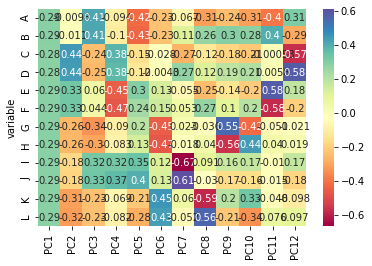

In [16]:
ax = sns.heatmap(loading_df, annot=True, cmap='Spectral')
plt.show()

In [17]:
#Principal component (PC) retention
#get eigenvalues (from PC1 to PC6)
pca_out.explained_variance_

array([1.17149335e+01, 2.48031198e-01, 2.18662099e-02, 9.80570677e-03,
       3.68963104e-03, 1.69397909e-03, 1.99971412e-04, 1.59516012e-04,
       1.43038624e-04, 1.24380355e-04, 1.00639902e-04, 6.76209096e-05])

In [18]:
#get screen plot (for scree or elbow test)


In [19]:
cluster.screeplot(obj=[pc_list, pca_out.explained_variance_ratio_])
#scree plot will be saved in the same directory with name screenplot.png

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


In [20]:
#PCA loadings plot
#get PCA loadings plots (2D and 3D)
#2D
cluster.pcaplot(x=loadings[0], y=loadings[1], labels=df.columns.values, 
    var1=round(pca_out.explained_variance_ratio_[0]*100, 2),
    var2=round(pca_out.explained_variance_ratio_[1]*100, 2))


In [21]:
# 3D
cluster.pcaplot(x=loadings[0], y=loadings[1], z=loadings[2],  labels=df.columns.values, 
    var1=round(pca_out.explained_variance_ratio_[0]*100, 2), var2=round(pca_out.explained_variance_ratio_[1]*100, 2), 
    var3=round(pca_out.explained_variance_ratio_[2]*100, 2))

In [22]:
#PCA biplot
pca_scores = PCA().fit_transform(df_st)

#get 2D biplot
cluster.biplot(cscore=pca_scores, loadings=loadings, labels=df.columns.values, var1=round(pca_out.explained_variance_ratio_[0]*100, 2),
    var2=round(pca_out.explained_variance_ratio_[1]*100, 2))

#get 3D biplot
cluster.biplot(cscore=pca_scores, loadings=loadings, labels=df.columns.values, 
    var1=round(pca_out.explained_variance_ratio_[0]*100, 2), var2=round(pca_out.explained_variance_ratio_[1]*100, 2), 
    var3=round(pca_out.explained_variance_ratio_[2]*100, 2))
